# Factor Analysis: Educational Assessment Data

This analysis demonstrates Factor Analysis (FA) to identify latent constructs
underlying student assessment performance. We'll explore how FA differs from PCA
by focusing on shared variance and latent factor interpretation.

**Learning objectives:**
- Apply Factor Analysis to discover latent psychological constructs
- Understand communalities and uniquenesses in measurement models
- Use factor rotation to achieve simple structure
- Compare Factor Analysis with Principal Component Analysis
- Interpret factor loadings for construct validation

## Import Libraries and Setup

In [2]:
import sys
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from factor_analyzer import FactorAnalyzer
from factor_analyzer.factor_analyzer import calculate_bartlett_sphericity, calculate_kmo
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# Simple logger
import logging

logger = logging.getLogger(__name__)

## Data Loading and Exploration

In [3]:
script_dir = Path.cwd()
data_path = script_dir / "educational.csv"

if not data_path.exists():
    logger.error(f"Data file not found: {data_path}")
    logger.info("Run 'fetch_educational.py' to generate the required data file")
    sys.exit(1)

df = pd.read_csv(data_path)
logger.info(
    f"Loaded dataset: {len(df)} students, {len(df.columns) - 1} assessment variables"
)

# Extract assessment variables (exclude Student ID)
X = df.iloc[:, 1:]
variable_names = list(X.columns)

logger.info(f"Assessment variables: {variable_names}")
logger.info(f"Data shape: {X.shape}")

## Data Standardization

Factor Analysis requires standardized data to ensure variables contribute equally
to the factor solution, regardless of their original measurement scales.

In [4]:
scaler = StandardScaler()
X_standardized = scaler.fit_transform(X)

logger.info("Data standardized: mean ≈ 0, std ≈ 1 for all variables")

## Factor Analysis Assumptions Testing

Before proceeding with Factor Analysis, we must verify that our data meets
key statistical assumptions for meaningful factor extraction.

In [5]:
# Test statistical assumptions
chi_square_value, p_value = calculate_bartlett_sphericity(X_standardized)
kmo_all, kmo_model = calculate_kmo(X_standardized)

logger.info("Factor Analysis Assumptions Testing:")
logger.info("\nBartlett's Test of Sphericity:")
logger.info(f"  Chi-square statistic: {chi_square_value:.3f}")
logger.info(f"  p-value: {p_value:.6f}")
if p_value < 0.05:
    logger.info("  ✓ Significant - variables are sufficiently correlated for FA")
else:
    logger.info("  ✗ Not significant - FA may not be appropriate")

logger.info("\nKaiser-Meyer-Olkin (KMO) Test:")
logger.info(f"  Overall Measure of Sampling Adequacy: {kmo_model:.3f}")
if kmo_model > 0.9:
    adequacy = "Excellent"
elif kmo_model > 0.8:
    adequacy = "Good"
elif kmo_model > 0.6:
    adequacy = "Acceptable"
else:
    adequacy = "Unacceptable"
logger.info(f"  Interpretation: {adequacy} sampling adequacy")

### Individual Variable Adequacy

Each variable's individual KMO value indicates how well it can be predicted
from the other variables in the analysis.

In [6]:
logger.info("\nIndividual Variable Sampling Adequacy:")
for i, var_name in enumerate(variable_names):
    msa_value = kmo_all[i]
    logger.info(f"  {var_name}: {msa_value:.3f}")

# Flag any problematic variables
low_msa_vars = [
    var_name for i, var_name in enumerate(variable_names) if kmo_all[i] < 0.6
]
if low_msa_vars:
    logger.warning(f"Variables with low MSA (<0.6): {low_msa_vars}")
else:
    logger.info("All variables show adequate sampling adequacy (MSA ≥ 0.6)")

Variables with low MSA (<0.6): ['MathTest', 'VerbalTest', 'SocialSkills', 'Leadership']


## Factor Extraction with Principal Axis Factoring

We'll extract factors using Principal Axis Factoring (PAF), which:
- Focuses on shared variance among variables (common factors)
- Estimates communalities iteratively
- Distinguishes between common and unique variance

In [7]:
# Determine number of factors to extract
n_factors = 2  # Based on theoretical expectation of cognitive + social factors

fa_unrotated = FactorAnalyzer(n_factors=n_factors, rotation=None, method="principal")
fa_unrotated.fit(X_standardized)

# Verify successful extraction
if fa_unrotated.loadings_ is None:
    logger.error("Factor extraction failed - no loadings produced")
    sys.exit(1)

logger.info(f"Factor Analysis Results ({n_factors} factors extracted):")
eigenvalues_fa = fa_unrotated.get_eigenvalues()[0]
logger.info(f"Eigenvalues: {np.round(eigenvalues_fa[:n_factors], 3)}")

/home/julihocc/ma2003b/ma2003b.worktrees/dev/.venv/lib/python3.12/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


### Communalities and Variance Decomposition

Each variable's variance is decomposed into:
- **Communality (h²)**: Variance explained by common factors
- **Uniqueness (u²)**: Variance unique to the variable (including error)

In [8]:
communalities = fa_unrotated.get_communalities()
uniquenesses = 1 - communalities

logger.info("\nVariance Decomposition (Communalities and Uniquenesses):")
for i, var_name in enumerate(variable_names):
    h2 = communalities[i]
    u2 = uniquenesses[i]
    logger.info(f"  {var_name}: h² = {h2:.3f}, u² = {u2:.3f}")

# Analyze overall variance structure
factor_variance = np.sum(communalities)
total_variance = len(variable_names)  # For standardized data
variance_explained = factor_variance / total_variance

logger.info("\nOverall Variance Analysis:")
logger.info(f"Total standardized variance: {total_variance:.1f}")
logger.info(f"Common variance (Σh²): {factor_variance:.3f}")
logger.info(f"Proportion of variance explained by factors: {variance_explained:.1%}")
logger.info(f"Average communality: {np.mean(communalities):.3f}")

**Interpreting Communalities:**

- **High communality (h² > 0.6)**: Variable strongly related to common factors
- **Moderate communality (0.3 < h² < 0.6)**: Moderate factor relationship
- **Low communality (h² < 0.3)**: Mostly unique variance, weak factor loading

Variables with very low communalities may be candidates for removal
or may represent additional factors not captured in the current solution.

## Factor Rotation for Simple Structure

Factor rotation improves interpretability without changing the fundamental solution.
Varimax rotation seeks "simple structure" where each variable loads primarily on one factor.

In [9]:
fa_rotated = FactorAnalyzer(n_factors=n_factors, rotation="varimax", method="principal")
fa_rotated.fit(X_standardized)

loadings_unrotated = fa_unrotated.loadings_
loadings_rotated = fa_rotated.loadings_

# Safety check for rotation success
if loadings_rotated is None:
    logger.warning("Varimax rotation failed, using unrotated solution")
    loadings_rotated = loadings_unrotated
    fa_rotated = fa_unrotated

logger.info("\nFactor Loadings Comparison (Unrotated vs. Varimax Rotated):")

# Create comparison table
comparison_df = pd.DataFrame(
    {
        "Variable": variable_names,
        "Unrot_F1": loadings_unrotated[:, 0],
        "Unrot_F2": loadings_unrotated[:, 1],
        "Rotated_F1": loadings_rotated[:, 0],
        "Rotated_F2": loadings_rotated[:, 1],
    }
)

print(comparison_df.round(3))

       Variable  Unrot_F1  Unrot_F2  Rotated_F1  Rotated_F2
0      MathTest    -0.681     0.698      -0.147       0.964
1    VerbalTest    -0.663     0.690      -0.137       0.947
2  SocialSkills     0.724     0.613       0.945       0.077
3    Leadership     0.791     0.539       0.957      -0.023
4    RandomVar1     0.384     0.133       0.390      -0.115
5    RandomVar2    -0.024    -0.452      -0.283      -0.354


/home/julihocc/ma2003b/ma2003b.worktrees/dev/.venv/lib/python3.12/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


### Factor Loading Interpretation

**Rotation benefits:**
- **Simple structure**: Variables load primarily on one factor
- **Clearer interpretation**: Easier to identify what each factor represents
- **Practical meaning**: Factors align better with theoretical constructs

**Loading interpretation guidelines:**
- **|loading| > 0.6**: Strong factor relationship
- **0.3 < |loading| < 0.6**: Moderate relationship
- **|loading| < 0.3**: Weak/negligible relationship

## Factor Loading Visualization

Heatmaps provide visual comparison of loading patterns before and after rotation.

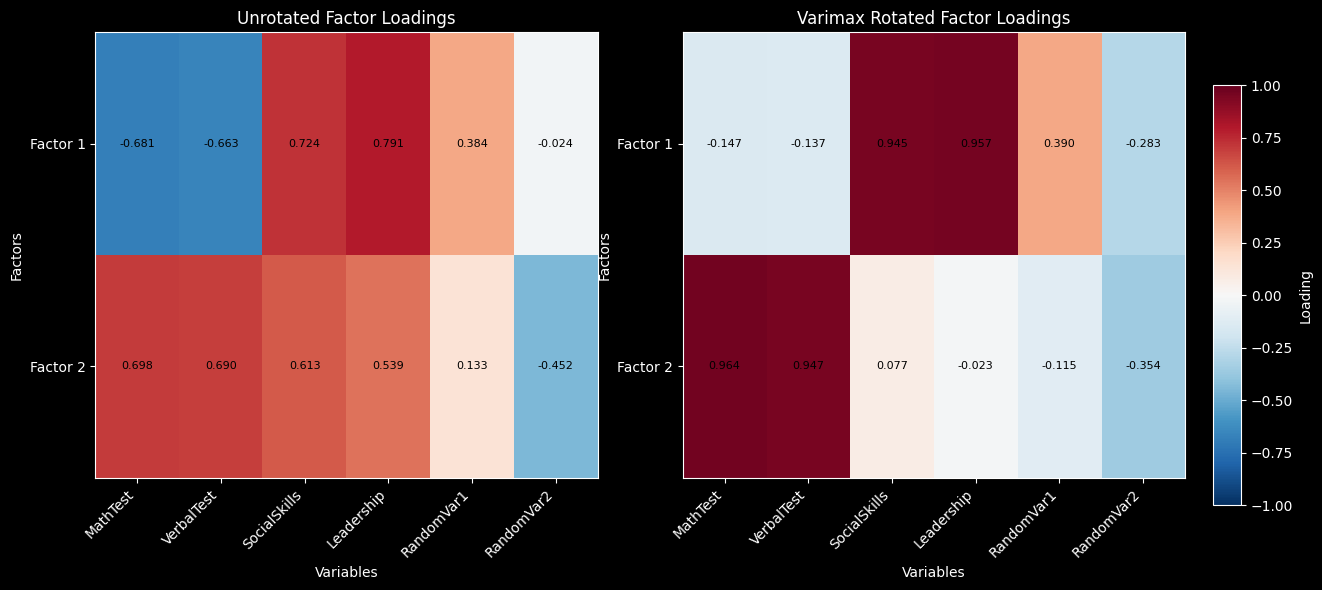

In [15]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

# Unrotated loadings heatmap using matplotlib imshow
im1 = ax1.imshow(
    loadings_unrotated.T,
    cmap="RdBu_r",
    aspect="auto",
    vmin=-1,
    vmax=1,
)
ax1.set_title("Unrotated Factor Loadings")
ax1.set_xlabel("Variables")
ax1.set_ylabel("Factors")
ax1.set_xticks(range(len(variable_names)))
ax1.set_xticklabels(variable_names, rotation=45, ha="right")
ax1.set_yticks(range(n_factors))
ax1.set_yticklabels([f"Factor {i + 1}" for i in range(n_factors)])

# Add annotations
for i in range(n_factors):
    for j in range(len(variable_names)):
        text = ax1.text(
            j,
            i,
            f"{loadings_unrotated[j, i]:.3f}",
            ha="center",
            va="center",
            color="black",
            fontsize=8,
        )

# Rotated loadings heatmap using matplotlib imshow
im2 = ax2.imshow(
    loadings_rotated.T,
    cmap="RdBu_r",
    aspect="auto",
    vmin=-1,
    vmax=1,
)
ax2.set_title("Varimax Rotated Factor Loadings")
ax2.set_xlabel("Variables")
ax2.set_ylabel("Factors")
ax2.set_xticks(range(len(variable_names)))
ax2.set_xticklabels(variable_names, rotation=45, ha="right")
ax2.set_yticks(range(n_factors))
ax2.set_yticklabels([f"Factor {i + 1}" for i in range(n_factors)])

# Add annotations
for i in range(n_factors):
    for j in range(len(variable_names)):
        text = ax2.text(
            j,
            i,
            f"{loadings_rotated[j, i]:.3f}",
            ha="center",
            va="center",
            color="black",
            fontsize=8,
        )

# Adjust layout and add colorbar to the right
plt.tight_layout()
fig.subplots_adjust(right=0.85)  # Make room for colorbar
cbar_ax = fig.add_axes([0.87, 0.15, 0.02, 0.7])  # Position for colorbar
cbar = fig.colorbar(im1, cax=cbar_ax)
cbar.set_label("Loading")

loadings_path = script_dir / "fa_loadings.png"
plt.savefig(loadings_path, dpi=150, bbox_inches="tight")
logger.info(f"Factor loadings heatmap saved: {loadings_path}")
# plt.show()  # Removed to avoid blocking

## Factor Analysis vs PCA Comparison

Direct comparison reveals fundamental differences between these two approaches
to multivariate data analysis.

In [11]:
# Run PCA for comparison
pca = PCA()
pca_scores = pca.fit_transform(X_standardized)
pca_loadings = pca.components_.T * np.sqrt(pca.explained_variance_)

# Get factor scores
fa_scores = fa_rotated.transform(X_standardized)

logger.info("\nFactor Analysis vs PCA Comparison:")

# Variance explanation comparison
pca_variance_2comp = pca.explained_variance_ratio_[:2].sum()
logger.info("\nVariance Explanation:")
logger.info(f"  PCA (first 2 components): {pca_variance_2comp:.1%} of total variance")
logger.info(f"  FA (2 factors): {variance_explained:.1%} of common variance")
logger.info(
    "  Key difference: PCA maximizes total variance, FA focuses on shared variance"
)

# Loading comparison
logger.info("\nLoading Pattern Comparison:")
comparison_detailed = pd.DataFrame(
    {
        "Variable": variable_names,
        "PCA_PC1": pca_loadings[:, 0],
        "PCA_PC2": pca_loadings[:, 1],
        "FA_F1": loadings_rotated[:, 0],
        "FA_F2": loadings_rotated[:, 1],
    }
)

print(comparison_detailed.round(3))

       Variable  PCA_PC1  PCA_PC2  FA_F1  FA_F2
0      MathTest   -0.684    0.701 -0.147  0.964
1    VerbalTest   -0.667    0.693 -0.137  0.947
2  SocialSkills    0.727    0.616  0.945  0.077
3    Leadership    0.795    0.542  0.957 -0.023
4    RandomVar1    0.386    0.134  0.390 -0.115
5    RandomVar2   -0.024   -0.455 -0.283 -0.354


/home/julihocc/ma2003b/ma2003b.worktrees/dev/.venv/lib/python3.12/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


## Eigenvalue Comparison: FA vs PCA

Scree plots reveal how eigenvalues differ between methods due to their
different approaches to variance decomposition.

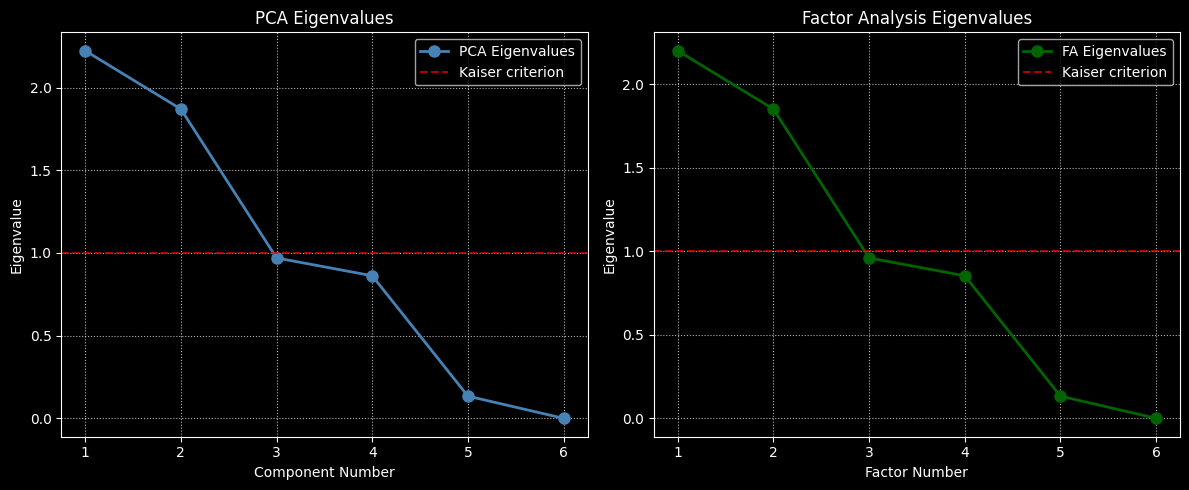

In [12]:
pca_eigenvalues = pca.explained_variance_
fa_eigenvalues = fa_unrotated.get_eigenvalues()[0]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
components = np.arange(1, len(pca_eigenvalues) + 1)

# PCA scree plot
ax1.plot(
    components,
    pca_eigenvalues,
    "o-",
    linewidth=2,
    color="steelblue",
    markersize=8,
    label="PCA Eigenvalues",
)
ax1.axhline(y=1.0, color="red", linestyle="--", alpha=0.7, label="Kaiser criterion")
ax1.set_xlabel("Component Number")
ax1.set_ylabel("Eigenvalue")
ax1.set_title("PCA Eigenvalues")
ax1.set_xticks(components)
ax1.grid(True, linestyle=":", alpha=0.7)
ax1.legend()

# FA scree plot
ax2.plot(
    components,
    fa_eigenvalues,
    "o-",
    linewidth=2,
    color="darkgreen",
    markersize=8,
    label="FA Eigenvalues",
)
ax2.axhline(y=1.0, color="red", linestyle="--", alpha=0.7, label="Kaiser criterion")
ax2.set_xlabel("Factor Number")
ax2.set_ylabel("Eigenvalue")
ax2.set_title("Factor Analysis Eigenvalues")
ax2.set_xticks(components)
ax2.grid(True, linestyle=":", alpha=0.7)
ax2.legend()

plt.tight_layout()
scree_path = script_dir / "fa_scree.png"
plt.savefig(scree_path, dpi=150, bbox_inches="tight")
logger.info(f"Eigenvalue comparison saved: {scree_path}")
plt.show()

**Eigenvalue pattern differences:**

- **FA eigenvalues**: Generally lower because they reflect only common variance
- **PCA eigenvalues**: Higher because they include both common and unique variance
- **Kaiser criterion**: May suggest different optimal numbers for FA vs PCA
- **Theoretical focus**: FA prioritizes meaningful factors over variance maximization

## Factor Structure Interpretation and Validation

Analyze the extracted factors to understand what psychological constructs
they represent and how well they align with theoretical expectations.

In [14]:
# Identify salient loadings (commonly |loading| > 0.4)
loading_threshold = 0.4

logger.info(f"\nFactor Structure Analysis (threshold = {loading_threshold}):")
for factor_idx in range(n_factors):
    factor_name = f"Factor {factor_idx + 1}"
    salient_vars = []

    for var_idx, var_name in enumerate(variable_names):
        loading = loadings_rotated[var_idx, factor_idx]
        if abs(loading) > loading_threshold:
            salient_vars.append(f"{var_name} ({loading:+.3f})")

    logger.info(
        f"  {factor_name}: {', '.join(salient_vars) if salient_vars else 'No salient loadings'}"
    )

# Analyze communality patterns
meaningful_vars = ["MathTest", "VerbalTest", "SocialSkills", "Leadership"]
random_vars = ["RandomVar1", "RandomVar2"]

if all(var in variable_names for var in meaningful_vars + random_vars):
    meaningful_h2 = [
        communalities[variable_names.index(var)] for var in meaningful_vars
    ]
    random_h2 = [communalities[variable_names.index(var)] for var in random_vars]

    logger.info("\nCommunality Pattern Analysis:")
    logger.info(
        f"  Meaningful variables (cognitive/social): mean h² = {np.mean(meaningful_h2):.3f}"
    )
    logger.info(f"  Random variables (noise): mean h² = {np.mean(random_h2):.3f}")

    if np.mean(meaningful_h2) > np.mean(random_h2) * 1.5:
        logger.info("  ✓ Factor structure successfully distinguishes signal from noise")
    else:
        logger.info(
            "  ⚠ Mixed signal-noise separation - consider alternative solutions"
        )
else:
    logger.info("\nExpected variable names not found - skipping pattern analysis")

## Summary and Method Selection Guidelines

This Factor Analysis demonstrates key concepts for latent variable modeling:

**Factor Analysis advantages demonstrated:**
- **Theoretical grounding**: Models specific latent constructs (cognitive, social abilities)
- **Measurement model**: Separates common variance from measurement error
- **Simple structure**: Rotation achieves cleaner variable-factor relationships
- **Communality estimates**: Reveals how much variance is shared vs. unique

**When to choose Factor Analysis:**
- Testing specific theories about latent psychological constructs
- Developing or validating measurement instruments
- Modeling common variance while acknowledging measurement error
- Interpreting results in terms of theoretical constructs

**When to choose PCA instead:**
- Primary goal is data reduction or compression
- Maximizing explained variance is the priority
- No theoretical model for underlying structure
- Computational efficiency is critical

**Key methodological insights:**
- **Assumption testing**: KMO and Bartlett's tests confirm FA appropriateness
- **Rotation benefits**: Varimax rotation dramatically improves interpretability
- **Communality interpretation**: Distinguishes reliable measurement from noise
- **Construct validation**: Loading patterns should align with theoretical expectations

**Next applications:**
- Explore oblique rotation when factors may be correlated
- Use confirmatory factor analysis to test specific theoretical models
- Apply to real datasets where factor structure is unknown
- Combine with other multivariate methods for comprehensive analysis